# Foehnix timseries
This notebook is for setting up the foehnix models and plotting timeseries with the dataset which contains station data from McCall and ERA5 data in UTC format.
The foehnix models should be set up after Georgs input in the following way:
1. Wind filter [90, 270]:
- Model 1 with Wind speed JJMC principal, Tdiff of AHAB to ERA5 800 (upstream/crest/McCall?) and RH as concomitant. 
- Model 2 with same set up but Tdiff JJMC to ERA5 800 and ADDITIONALLY  filter for foehn probability > 0.5 of Model 1

2. Wind filter [110, 250]:
- Model 1 with Wind speed JJMC principal, Tdiff of AHAB to ERA5 800 (upstream/crest/McCall?) and RH as concomitant. 
- Model 2 with same set up but Tdiff JJMC to ERA5 800 and ADDITIONALLY  filter for foehn probability > 0.5 of Model 1

The plot of the timeseries should than contain:
- temperature anomalies (observation - mean T value/ monthly mean T value)
- humidity
- Wind speed / direction
- one subplot for each of the models

In [28]:
#import packages
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#import seaborn as sns
from datetime import datetime, timedelta
import foehnix


#plot setup
#%matplotlib inline
#plt.style.use('seaborn') # pretty matplotlib plots
#plt.rc('font', size=14)
#plt.rc('figure', titlesize=18)
#plt.rc('axes', labelsize=15)
#plt.rc('axes', titlesize=18)

In [29]:
#load data
#read data
#folder = r"C:\Users\leopo\Master\Thesis\data\data_raw"
folder = r"C:\Users\leopo\Master\Thesis\Code\Rfoehnix\final_version"
#file = r"\foehn_datasetera5_utc.xlsx"
file = r"\foehnix_input_finalversion.xlsx"

foehn_dataset = pd.read_excel(folder+file, index_col = "utc_time",  na_values = "NAN")
#foehn_dataset = pd.read_excel(folder+file, index_col = "utc_time",  na_values = "")

## Tdiff AHAB, JJMC, ERA5 800 hPa
calculate temperature differences of JJMC and AHAB to 800 hPa temperature of ERA5. Use the upstream grid point first, one can still try the other grid points later.

In [30]:
foehn_dataset.columns

Index(['Year', 'Day', 'Time', '3m_T_ahab', '1m_T_ahab', 'pressure_ahab',
       '2m_T_jjmc', '2m_RH_jjmc', '3m_Windspeed_jjmc', '3m_Winddir_jjmc',
       '1m_Windspeed_jjmc', '1m_Winddir_jjmc', 'pressure_jjmc', '1m_T_jjmc',
       '1m_RH_jjmc', '3m_T_jjmc', '3m_RH_jjmc', '3m_gust_jjmc', '1m_gust_jjmc',
       'q_s_jjmc', 'windspeed_ahab', 'winddir_ahab', 'RH_ahab', 'Datetime',
       't_upstream800', 'windspeed_upstream800', 'winddir_upstream800',
       't_crest800', 'windspeed_crest800', 'winddir_crest800', 't_upstream775',
       'windspeed_upstream775', 'winddir_upstream775', 't_crest775',
       'windspeed_crest775', 'winddir_crest775', 't_upstream750',
       'windspeed_upstream750', 'winddir_upstream750', 't_crest750',
       'windspeed_crest750', 'winddir_crest750', 't_upstream700',
       'windspeed_upstream700', 'winddir_upstream700', 't_crest700',
       'windspeed_crest700', 'winddir_crest700', 't_mccall800',
       'windspeed_mccall800', 'winddir_mccall800', 't_mccall750',

In [31]:
#Tdiff AHAB
for point in ["upstream", "crest", "mccall"]:
    foehn_dataset[f"tdiff_ahab_{point}800"] = foehn_dataset["3m_T_ahab"] - foehn_dataset[f"t_{point}800"]
    foehn_dataset[f"tdiff_jjmc_{point}800"] = foehn_dataset["2m_T_jjmc"] - foehn_dataset[f"t_{point}800"]

#Tdiff McCall
foehn_dataset["tdiff_mccall800_crest800"] = foehn_dataset["t_mccall800"] - foehn_dataset["t_crest800"]
foehn_dataset["tdiff_mccall800_crest750"] = foehn_dataset["t_mccall800"] - foehn_dataset["t_crest750"]

### only data after 17.08.2008

In [32]:
foehn_dataset = foehn_dataset["2008-08-17 01:00:00":]

# Foehnix models

In [33]:
#filter for ahab
#filter1_ahab = {'winddir_crest800':[90, 270]}
filter1_ahab = {'winddir_crest800':[90, 270], 'winddir_ahab':[90, 270]}
filter1_era5 = {'winddir_crest800':[90, 270], 'winddir_mccall800':[90, 270]}
#filter2_ahab = {'winddir_crest800':[110, 250]}
filter2_ahab = {'winddir_crest800':[90, 270], 'winddir_ahab':[80, 280]}
filter2_era5 = {'winddir_crest800':[110, 250], 'winddir_mccall800':[110, 250]}

In [34]:
#model setup 1
#model 1 wind speed principal, Tdiff ahab - 800hPa and RH JJMC concomitant
mod_tdiffahab_filter1 = foehnix.Foehnix("windspeed_ahab", foehn_dataset,  
                         concomitant = ["Tdiff_ahab_crest800", "RH_ahab"], filter_method = filter1_ahab, switch = False, maxit = 200)
mod_tdiffahab_filter2 = foehnix.Foehnix("windspeed_ahab", foehn_dataset,   
                         concomitant = ["Tdiff_ahab_crest800", "RH_ahab"], filter_method = filter2_ahab, switch = False, maxit = 200)

mod_tdiffera5_filter1 = foehnix.Foehnix("windspeed_ahab", foehn_dataset,  
                         concomitant = ["Tdiff_ahab_crest800", "RH_ahab"], filter_method = filter1_era5, switch = False)
#mod_tdiffera5_filter2 = foehnix.Foehnix("windspeed_ahab", foehn_dataset,  
#                         concomitant = ["Tdiff_ahab_crest800", "RH_ahab"], filter_method = filter2_era5, maxit = 200, switch = False)

#mod_era5only_wind_t800 = foehnix.Foehnix("windspeed_mccall800", foehn_dataset,
 #                                   concomitant = "tdiff_mccall800_crest800", filter_method = filter1_era5, maxit = 500, switch = False)
#mod_era5only_wind_t750 = foehnix.Foehnix("windspeed_mccall800", foehn_dataset,
#                                    concomitant = "tdiff_mccall800_crest750", filter_method = filter1_era5, maxit = 500, switch = False)
#mod_era5only_t800_wind = foehnix.Foehnix("tdiff_mccall800_crest800", foehn_dataset,
#                                    concomitant = "windspeed_mccall800", filter_method = filter1_era5, maxit = 500, switch = False)
#mod_era5only_t750_wind = foehnix.Foehnix("tdiff_mccall800_crest750", foehn_dataset,
#                                    concomitant = "windspeed_mccall800", filter_method = filter1_era5, maxit = 500, switch = False)


2024-08-30 16:48:47: foehnix.foehnix_filter: Applied limit-filter [90.0 270.0] to key winddir_crest800
2024-08-30 16:48:47: foehnix.foehnix_filter: Applied limit-filter [90.0 270.0] to key winddir_ahab
2024-08-30 16:48:47: foehnix.foehnix: Calling Foehnix.unreg_fit
2024-08-30 16:48:47: foehnix.foehnix: EM iteration 1/200, ll =  -56755.73
2024-08-30 16:48:47: foehnix.foehnix: EM iteration 2/200, ll =  -55515.91
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 3/200, ll =  -54899.12
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 4/200, ll =  -54554.58
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 5/200, ll =  -54360.47
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 6/200, ll =  -54253.23
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 7/200, ll =  -54196.58
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 8/200, ll =  -54169.32
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 9/200, ll =  -54158.99
2024-08-30 16:48:48: foehnix.foehnix: EM iteration 10/200, ll =  -54

In [35]:
mod_era5only_t800_wind.summary()

NameError: name 'mod_era5only_t800_wind' is not defined

In [36]:
mod_tdiffera5_filter1.summary()


Number of observations (total)    55871 (0 due to inflation)
Removed due to missing values      7192 (12.9 percent)
Outside defined wind sector       21502 (38.5 percent)
Used for classification           27177 (48.6 percent)

Climatological foehn occurance 13.36 percent (on n = 48679)
Mean foehn probability 17.19 percent (on n = 48679)

Log-likelihood: -69835.0, 7 effective degrees of freedom
Corresponding AIC = 139684.0, BIC = 139741.5

Number of EM iterations 11/100 (converged)
Time required for model estimation: 1.9 seconds


In [37]:
mod_tdiffera5_filter1.coef

mu1                                                      2.166367
logsd1                                                   0.267636
mu2                                                      6.031428
logsd2                                                   1.149253
concomitants    Intercept             -0.340352
Tdiff_ahab_cre...
dtype: object

In [38]:
mod_tdiffera5_filter1.coef.concomitants

Intercept             -0.340352
Tdiff_ahab_crest800   -0.067708
RH_ahab               -0.008465
dtype: float64

In [39]:
#add probability of ahab foehnix model to dataframe
foehn_dataset["prob_ahab_filter1"] = mod_tdiffahab_filter1.prob["prob"].copy().values
foehn_dataset["prob_era5_filter1"] = mod_tdiffera5_filter1.prob["prob"].copy().values
foehn_dataset["prob_ahab_filter2"] = mod_tdiffahab_filter2.prob["prob"].copy().values
#foehn_dataset["prob_era5_filter2"] = mod_tdiffera5_filter2.prob["prob"].copy().values
#foehn_dataset["prob_era5_only"] = mod_era5only_t800_wind.prob["prob"].copy().values

#pairwise maximum
#foehn_dataset["prob_combined_filter1"] = foehn_dataset[["prob_ahab_filter1", "prob_era5_filter1"]].max(axis=1)
#foehn_dataset["prob_combined_filter2"] = foehn_dataset[["prob_ahab_filter2", "prob_era5_filter2"]].max(axis=1)

In [40]:
#filter for jjmc
filterjjmc1 = {'3m_Winddir_jjmc':[110, 240], 'winddir_crest800':[90, 270], 
              'winddir_mccall800':[90, 270], 'prob_era5_filter1':[0.5, 1.01]} #   
filterjjmc2 = {'3m_Winddir_jjmc':[110, 240], 'winddir_crest800':[90, 270], 
               'winddir_ahab':[90, 270], 'prob_ahab_filter1':[0.5, 1.01]} # 
filterjjmc3 = {'3m_Winddir_jjmc':[110, 240], 'winddir_crest800':[90, 270], 
              'winddir_ahab':[80, 280], 'prob_ahab_filter2':[0.5, 1.01]}

In [41]:
#model setup 2
#model 2 wind speed principal, Tdiff jjmc - 800hPa and RH JJMC concomitant
mod_jjmc_1 = foehnix.Foehnix("3m_Windspeed_jjmc", foehn_dataset,  
                         concomitant = ["Tdiff_jjmc_ahab", "2m_RH_jjmc"], filter_method = filterjjmc1, 
                                        switch = False, maxit = 700)
mod_jjmc_2 = foehnix.Foehnix("3m_Windspeed_jjmc", foehn_dataset,   
                         concomitant = ["Tdiff_jjmc_ahab", "2m_RH_jjmc"], filter_method = filterjjmc2, 
                                        switch = False, maxit = 600)
mod_jjmc_3 = foehnix.Foehnix("3m_Windspeed_jjmc", foehn_dataset,   
                         concomitant = ["Tdiff_jjmc_ahab", "2m_RH_jjmc"], filter_method = filterjjmc3, 
                                        switch = False, maxit = 600)

2024-08-30 16:49:53: foehnix.foehnix_filter: Applied limit-filter [110.0 240.0] to key 3m_Winddir_jjmc
2024-08-30 16:49:53: foehnix.foehnix_filter: Applied limit-filter [90.0 270.0] to key winddir_crest800
2024-08-30 16:49:53: foehnix.foehnix_filter: Applied limit-filter [90.0 270.0] to key winddir_mccall800
2024-08-30 16:49:53: foehnix.foehnix_filter: Applied limit-filter [0.5 1.0] to key prob_era5_filter1
2024-08-30 16:49:53: foehnix.foehnix: Calling Foehnix.unreg_fit
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 1/700, ll =  -12616.82
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 2/700, ll =  -12312.70
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 3/700, ll =  -12124.55
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 4/700, ll =  -12001.78
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 5/700, ll =  -11915.68
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 6/700, ll =  -11851.04
2024-08-30 16:49:53: foehnix.foehnix: EM iteration 7/700, ll =  -11800.24
2024-08

In [42]:
#add probability of ahab foehnix model to dataframe
foehn_dataset["prob_jjmc_filter1"] = mod_jjmc_1.prob["prob"].copy().values
foehn_dataset["prob_jjmc_filter2"] = mod_jjmc_2.prob["prob"].copy().values
foehn_dataset["prob_jjmc_filter3"] = mod_jjmc_3.prob["prob"].copy().values

In [43]:
mod_jjmc_1.coef

mu1                                                      3.072212
logsd1                                                   0.438755
mu2                                                      5.809648
logsd2                                                   0.843514
concomitants    Intercept         -8.984863
Tdiff_jjmc_ahab   ...
dtype: object

In [44]:
mod_jjmc_1.coef.concomitants

Intercept         -8.984863
Tdiff_jjmc_ahab    2.138059
2m_RH_jjmc        -0.020539
dtype: float64

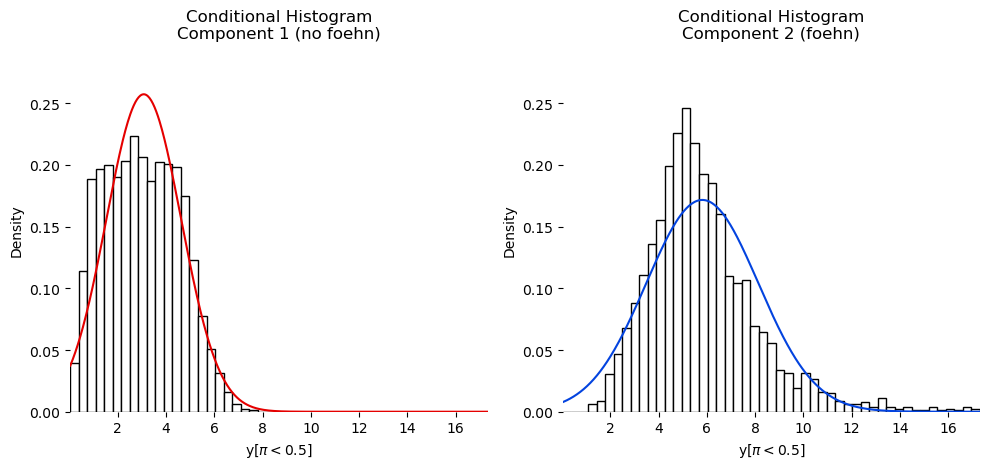

In [46]:
mod_jjmc_1.plot(which = "hist")

In [49]:
mod_jjmc_1.summary()


Number of observations (total)    55871 (0 due to inflation)
Removed due to missing values     12352 (22.1 percent)
Outside defined wind sector       38482 (68.9 percent)
Used for classification            5037 (9.0 percent)

Climatological foehn occurance 5.17 percent (on n = 43519)
Mean foehn probability 5.04 percent (on n = 43519)

Log-likelihood: -11568.9, 7 effective degrees of freedom
Corresponding AIC = 23151.8, BIC = 23197.4

Number of EM iterations 40/700 (converged)
Time required for model estimation: 1.2 seconds


### save dataset with foehn probabilities

utc_time
2008-08-17 01:00:00    0.0
2008-08-17 02:00:00    0.0
2008-08-17 03:00:00    0.0
2008-08-17 04:00:00    0.0
2008-08-17 05:00:00    0.0
                      ... 
2014-12-31 19:00:00    NaN
2014-12-31 20:00:00    NaN
2014-12-31 21:00:00    NaN
2014-12-31 22:00:00    NaN
2014-12-31 23:00:00    NaN
Name: prob_jjmc_filter1, Length: 55871, dtype: float64

In [51]:
foehn_dataset.to_excel(r"C:\Users\leopo\Master\Thesis\Code\Rfoehnix\final_version\foehn_probability_era5_era5.xlsx")

In [63]:
foehn_dataset.columns

Index(['Year', 'Day', 'Time', '3m_T_ahab', '1m_T_ahab', 'pressure_ahab',
       'theta_ahab_jjmc', 'T_firn', 'pressure_firn', 'theta_firn_jjmc',
       '2m_T_jjmc', '2m_RH_jjmc', '3m_Windspeed_jjmc', '3m_Winddir_jjmc',
       '1m_Windspeed_jjmc', '1m_Winddir_jjmc', 'pressure_jjmc', 'Tdiff_ahab',
       'Tdiff_firn', 'theta_diff_ahab', 'theta_diff_firn', 'foehn_ahab',
       'foehn_firn', 'foehn_ahab_flag', 'foehn_firn_flag', '1m_T_jjmc',
       '1m_RH_jjmc', '3m_T_jjmc', '3m_RH_jjmc', '3m_gust_jjmc', '1m_gust_jjmc',
       'q_s_jjmc', 'windspeed_ahab', 'winddir_ahab', 'RH_ahab', 'Datetime',
       't_upstream800', 'windspeed_upstream800', 'winddir_upstream800',
       't_crest800', 'windspeed_crest800', 'winddir_crest800', 't_upstream775',
       'windspeed_upstream775', 'winddir_upstream775', 't_crest775',
       'windspeed_crest775', 'winddir_crest775', 't_upstream750',
       'windspeed_upstream750', 'winddir_upstream750', 't_crest750',
       'windspeed_crest750', 'winddir_crest750

### Plot timeseries

In [95]:
def plot_function(start, end, year = None):
    #make sure, the time is a pandas datetime
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    
    #reduce dataset
    foehn_jjmc_plot = foehn_dataset[start:end].copy()
    
    #plot    
    fig = plt.figure(figsize=(25,15))
    fig.tight_layout(pad=2.0)

    #plot temperatures and potential temperatures of AHAB and era5 levels
    ax1 = fig.add_subplot(5,1,1)
    #ax2 = ax1.twinx()
    fig.tight_layout(pad=2.0)
    #plot with anomaly
    ax1.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["2m_T_jjmc"] - foehn_jjmc_plot["2m_T_jjmc"].mean() , color = "red", linewidth = 3, label = "JJMC")
    ax1.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["3m_T_ahab"] - foehn_jjmc_plot["3m_T_ahab"].mean(), color = "blue", linewidth = 3, label = "AHAB")
    ax1.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["t_crest800"] - foehn_jjmc_plot["t_crest800"].mean(), color = "black", linewidth = 3, label = "ERA5 crest, 800 hPa")
    ax1.axhline(0, linestyle = "dashed")
    #plot with observed values
    #ax1.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["2m_T_jjmc"], color = "red", linewidth = 3, label = "JJMC")
    #ax1.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["3m_T_ahab"], color = "blue", linewidth = 3, label = "AHAB")
    #ax1.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["t_crest800"], color = "black", linewidth = 3, label = "ERA5 crest, 800 hPa")

    #make plot look good
    #ax1_upperlimit = 5*np.ceil(np.nanmax([foehn_jjmc_plot["2m_T_jjmc"], 
    #                                      foehn_jjmc_plot["3m_T_ahab"], foehn_jjmc_plot["t_crest800"]])/5)
    #ax1_lowerlimit = 5*np.floor(np.nanmin([foehn_jjmc_plot["2m_T_jjmc"], 
    #                                       foehn_jjmc_plot["3m_T_ahab"], foehn_jjmc_plot["t_crest800"]])/5)
    #y limits
    #ax1.set_ylim(ax1_lowerlimit, ax1_upperlimit), 
    #ax1.set_yticks(np.arange(ax1_lowerlimit, ax1_upperlimit, 5));
    ax1.set_ylabel("T anomaly [°C]", fontsize = 20); ax1.tick_params(axis='both', which='major', labelsize=20);
    ax1.set_xticklabels([])
    ax1.legend(bbox_to_anchor =(0.5,-0.3), loc='lower center', fontsize = 18, ncol = 5);
    #ax1.set_title("Temperature", fontsize = 20)

    ax2 = fig.add_subplot(5,1,2)
    #plot relative humidity
    #ax2.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["q_s_jjmc"], color = "green", label = "specific humidity JJMC")
    #ax2.set_ylim(0, 30); 
    #ax2_5 = ax2.twinx()
    ax2.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["2m_RH_jjmc"], color = "green", 
             label = "relative humidity JJMC")
    ax2.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["RH_ahab"], color = "green", 
             linestyle = "dashed", label = "relative humidity AHAB")
    ax2.set_ylim(0, 100.1); ax2.set_yticks([0, 20, 40, 60, 80, 100])
    ax2.tick_params(axis='both', which='major', labelsize=20); #ax2.set_title("rel. humidity");
    ax2.set_xticklabels([])
    ax2.set_ylabel("relative humidity [%]", fontsize = 20, color = "black")
    ax2.legend(bbox_to_anchor =(0.5,-0.26), loc='lower center', fontsize = 18, ncol = 2); 
    #ax2_5.legend(bbox_to_anchor =(0.65,-1.1), loc='lower center', fontsize = 20)

    
    #plot wind speed and direction
    #colors = ["red" if ((value >= 110) & (value <= 235)) else "black" for value in foehn_jjmc_plot["3m_Winddir_jjmc"]]
    ax4 = fig.add_subplot(5,1,3)
    #JJMC
    ax4.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["3m_Windspeed_jjmc"], color = "red", label = "ff JJMC")
    ax5 = ax4.twinx()
    ax5.scatter(foehn_jjmc_plot.index, foehn_jjmc_plot["3m_Winddir_jjmc"], color = 'red', s = 10, label = "dd JJMC")
    #ERA5
    ax4.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["windspeed_crest800"], color = "black", label = "ff ERA5 crest - 800 hPa")
    ax5.scatter(foehn_jjmc_plot.index, foehn_jjmc_plot["winddir_crest800"], color = 'black', s = 10, label = "dd ERA5 crest - 800 hPa")
    #AHAB
    ax4.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["windspeed_ahab"], color = "blue", label = "wind speed AHAB")
    ax5.scatter(foehn_jjmc_plot.index, foehn_jjmc_plot["winddir_mccall800"], color = 'blue', s = 10, label = "dd ERA5 McCall - 800 hPa")
    #ax5.scatter(foehn_jjmc_plot.index, foehn_jjmc_plot["winddir_mccall800"], color = 'cyan', s = 10, label = "dd ERA5 - 800 hPa")
    #ax5.axhline(110, linestyle = "dashed", color = "red", label = "foehn sector JJMC"); ax5.axhline(225, linestyle = "dashed", color = "red")

    # Set the transformation for the right y-axis (map 0-360 to 10-20)
    #ax4.set_ylim(0, 20); 
    right_y_limit = 360
    left_y_limit = 20
    trans = lambda x: ((x+10) * (left_y_limit / right_y_limit))
    ax4.set_ylim(0, 20); ax4.set_yticks([0, 5, 10, 15, 20]);
    ax5.set_ylim(trans(0), trans(right_y_limit))

    ax4.grid(color = "black", linewidth = 1, axis = "y")
    ax4.legend(bbox_to_anchor =(0.3,-0.36), loc='lower center', fontsize = 18, ncol = 3); 
    #ax4.set_title("wind speed and direction at JJMC, AHAB, ERA5 crest 800hPa", fontsize = 20)
    ax4.set_ylabel("wind speed [m/s]", fontsize = 20); ax5.set_ylabel("wind direction [°]", fontsize = 20)
    ax5.set_yticks([0, 90, 180, 270, 360]); ax5.grid(False)
    ax5.legend(bbox_to_anchor =(0.7,-0.36), loc='lower center', fontsize = 18, ncol = 3)
    ax4.tick_params(axis='both', which='major', labelsize=20)
    ax5.tick_params(axis='both', which='major', labelsize=20)
    ax4.set_xticklabels([]); ax5.set_xticklabels([])
    
        
    #foehnix models only with AWS data filter 90-270
    ax6 = fig.add_subplot(5,1,4)
    #theta-diff as principal
    ax6.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["prob_jjmc_filter1"], color = "black", 
             linewidth = 2, label = "JJMC")
    ax6.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["prob_ahab_filter1"], color = "black", 
             linestyle = "dashed", linewidth = 2, label = "AHAB")


    ax6.set_ylim(0,1.05); ax6.legend(bbox_to_anchor =(0.5,-0.4), loc='lower center', fontsize = 20, ncol = 2)
    ax6.set_title("Foehn probability, Wind speed, Tdiff, RH, [90°, 270°]", fontsize = 20); ax6.tick_params(axis='both', which='major', labelsize=20)
    ax6.tick_params(axis='x', labelsize=25)#, ax6.set_ylabel("Wind speed, Tdiff, RH [90°, 270°]", fontsize = 20)
    ax6.set_xticklabels([])
    
    
    #foehnix models only with AWS data, filter 110 - 250
    ax7 = fig.add_subplot(5,1,5)
    #theta-diff as principal
    ax7.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["prob_jjmc_filter2"], color = "black", 
             linewidth = 2, label = "JJMC")
    ax7.plot(foehn_jjmc_plot.index, foehn_jjmc_plot["prob_ahab_filter2"], color = "black", 
           linestyle = "dashed", linewidth = 2, label = "AHAB")


    ax7.set_ylim(0,1.05); #ax7.legend(bbox_to_anchor =(0.5,-0.5), loc='lower center', fontsize = 20, ncol = 2)
    ax7.set_title("Foehn probability, Wind speed, Tdiff, RH, [110°, 250°]", fontsize = 20); ax7.tick_params(axis='both', which='major', labelsize=20)
    ax7.tick_params(axis='x', labelsize=25)#, ax7.set_ylabel("Wind speed, Tdiff, RH, [110°, 250°]", fontsize = 20)

    
    plt.subplots_adjust(hspace=0.6)

    if year != None:
        plt.savefig(fr"C:\Users\leopo\Master\Thesis\Code\Rfoehnix\final_version\R_output\era5_era5_filter\plots\\{year}\\{(str(start))[0:10]}_{(str(end))[0:10]}.png", 
               bbox_inches="tight")
    else:
        plt.savefig(fr"C:\Users\leopo\Master\Thesis\Code\Rfoehnix\final_version\R_output\era5_era5_filter\plots\sel_events\\{(str(start))[0:10]}_{(str(end))[0:10]}.png", 
               bbox_inches="tight")
    plt.close()

In [28]:
plot_function("2011-01-14 00:00:00", "2009-01-19 08:00:00")

### some selected events

In [96]:
start_dates = ["2008-12-08 00:00:00", "2008-12-14 00:00:00", "2009-01-14 00:00:00", "2009-02-11 00:00:00", 
               "2009-04-26 00:00:00", "2011-11-30 00:00:00", "2012-01-01 00:00:00", "2012-09-15 00:00:00", 
              "2013-04-07 00:00:00", "2014-05-24 00:00:00"]
end_dates = ["2008-12-12 00:00:00", "2008-12-17 00:00:00", "2009-01-19 08:00:00", "2009-02-15 00:00:00", 
             "2009-04-29 00:00:00", "2011-12-11 00:00:00", "2012-01-13 00:00:00", "2012-09-25 00:00:00", 
            "2013-04-09 00:00:00", "2014-05-30 00:00:00"]

In [97]:
#call plot function
for start, end in zip(start_dates, end_dates):
    plot_function(start, end)

In [98]:
#year 2009
# Define the start date for the year 2009
for year in np.arange(2008, 2015):
    start_date1 = pd.to_datetime(f"{year}-01-01 00:00:00")
    start_date2 = start_date1 + timedelta(days=10)

    # Create a list of datetime objects with 10-day intervals
    date_list1 = [start_date1 + timedelta(days=10 * i) for i in range(37)]
    date_list2 = [start_date2 + timedelta(days=10 * i) for i in range(37)]

    for start, end in zip(date_list1, date_list2):
        plot_function(start, end, year)

In [81]:
np.arange(2008, 2015)

array([2008, 2009, 2010, 2011, 2012, 2013, 2014])

## seasonality of foehn winds
The Hovmoller plots show a maximum of foehn occurance during January. I want to plot additionally the frequency, just by average hours per month. 

In [33]:
#add column foehn yes = 1 or no = 0
foehn_dataset["foehn_yes_no"] = np.where(foehn_dataset["prob_jjmc_filter2"] > 0.5, 1, 0)

In [39]:
#caclulate monthly means
month_foehnnumber = foehn_dataset["foehn_yes_no"]["2009":].groupby(foehn_dataset["2009":].index.month).sum()

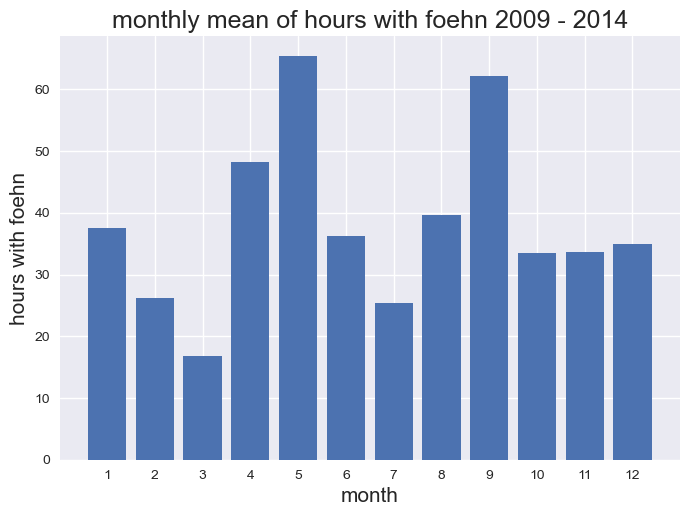

In [49]:
#barplot
plt.bar(np.arange(1,13), month_foehnnumber / 6)
plt.xticks(np.arange(1,13)); plt.xlabel("month")
plt.ylabel("hours with foehn")
plt.title("monthly mean of hours with foehn 2009 - 2014")
plt.savefig(r"C:\Users\leopo\Master\Thesis\images\foehnix_timeseries\mon_mean_foehnhours.png")

460

0.06388888888888888